## Bangla Abusive Word Detection Using Deep Learning 

In [ ]:
!pip install SpeechRecognition

     |████████████████████████████████| 32.8 MB 1.2 MB/s 


In [ ]:
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 91.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


### Import 

In [ ]:
### import 
# import speech_recognition as sr 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [ ]:
r = sr.Recognizer()

with sr.Microphone() as source: 
    print('Enter speech: ')
    audio = r.listen(source, phrase_time_limit=10)
    
    speech = r.recognize_google(audio, language='bn-BD')
    print("You said: {}".format(speech))


text_words = speech.split(' ')
text_words

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.text import one_hot 
from tensorflow.keras.layers import LSTM , Dropout, Bidirectional
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, BatchNormalization
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import tensorflow_hub as hub
import gensim

### Load Dataset

In [ ]:
# from google.colab import files
# uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/My Drive/IDP/Dataset/bengali_hate_speech.csv", usecols=['sentence', 'hate'], encoding='utf8')
df.rename(columns = {'sentence':'text', 'hate':'target'}, inplace = True)
# df = df.drop('label', axis='columns')
df = shuffle(df, random_state=8)
df.head(5)

,text,target
5365,ওটা তোর বাবার কুত্তার বাচ্চার তুরা আমার আল্লার...,1
9434,ভাবী তোমার হট দেবর আমি কেমন আছেন আপনি মিস দাও,1
19773,তাহেরী হলো আসল ভন্ড,0
29236,ইতিহাস পুনরাবৃত্তি হবে,0
3078,কোন গাছ বলদে এ নাটক পরিচালনা করছে আবাল,1


In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/IDP/Dataset/bangla_abusive.csv', encoding='utf8')
df1["target"].replace({0:1 , 1:1, 2:1,3:1}, inplace=True)
df1 = df1.drop(df1[df1.label == 'Geopolitical'].index)
df1 = df1.drop(df1[df1.label == 'Political'].index)
df1 = df1.drop('label', axis='columns')
df1 = shuffle(df1, random_state=8)
df1.tail(5)

,text,target
3898,এই মালাউন এর বাচ্চায় এম্নেই মরবো,1
4293,ভালো লাগলো ভাই কথা গুলো একদম মনের কথা বলছেন তা...,1
3636,এখানে শাকিবের ও দোষ আছে সে ইচ্ছে করলে আপুকে ভা...,1
2470,"শিখার বাবা আমার বাবার মত সৎ, এই বাবারাই কষট প...",1
799,আপনার কথার ধারা বোঝা যাচ্ছে আপনার হিন্দু দের প...,1


In [ ]:
df2 = pd.read_excel('/content/drive/My Drive/IDP/Dataset/train_data.xlsx')
df2.head()

,id,comment_text,toxic,threat,obscene,insult,racism,Unnamed: 7
0,10002.0,এই গুলার জায়গামতো চুঁচড়া লাগিয়ে দেয়া দরকার! যত...,1.0,0.0,0.0,1.0,0.0,NaN
1,10003.0,"আসিফ খানকির পোলা, তোর মারে কুত্তা দিয়ে চুদে তো...",1.0,0.0,1.0,1.0,0.0,NaN
2,10004.0,শুয়োরের জ্ঞান সীমিত তাই সারাদিন গাঁজাখোরদের মত...,1.0,0.0,0.0,1.0,0.0,NaN
3,10005.0,এই মাদ্রাসার হোগুরকে ডিলডো মেরে শাস্তি দেয়া হোক।,1.0,0.0,0.0,1.0,0.0,NaN
4,10006.0,নাস্তিকতা মানে ই মানুষিক রোগী ।,1.0,0.0,0.0,0.0,1.0,NaN


In [ ]:
df2.loc[(df2.insult==1) & (df2.toxic==0)]

,id,comment_text,toxic,threat,obscene,insult,racism,Unnamed: 7


In [ ]:
df2 = df2.drop(['id','threat', 'obscene', 'insult', 'racism','Unnamed: 7'], axis=1)
df2.rename(columns= {'comment_text':'text', 'toxic': 'target'}, inplace=True)
df2 = shuffle(df2, random_state=8)
df2.head()

,text,target
6381,আমরা মারা গেলে চোখ বুজে ফেলি... তারা?,0.0
2322,নয়াাখাইল্লা,1.0
8997,ইচ্ছেটাই আসল,0.0
5148,আমি সাথেসাথে হাঁটা থামিয়ে তার দিকে হাত নাড়ালাম,0.0
23,"যেই খানকীর পোলা নাস্তিক রা বিরোধীতা করছিস, তোদ...",1.0


In [ ]:
df2['text'].isna().sum()

1

In [ ]:
df2 = df2.drop(df2.loc[df2.text.isna()==True].index)
df2.isna().sum()

text      0
target    0
dtype: int64

In [ ]:
df2.shape

(10219, 2)

In [ ]:
df = pd.concat([df, df1, df2], axis=0)
df.head(5)

,text,target
5365,ওটা তোর বাবার কুত্তার বাচ্চার তুরা আমার আল্লার...,1.0
9434,ভাবী তোমার হট দেবর আমি কেমন আছেন আপনি মিস দাও,1.0
19773,তাহেরী হলো আসল ভন্ড,0.0
29236,ইতিহাস পুনরাবৃত্তি হবে,0.0
3078,কোন গাছ বলদে এ নাটক পরিচালনা করছে আবাল,1.0


In [ ]:
df.shape

(43365, 2)

In [ ]:
# import io
# df = pd.read_csv(io.BytesIO(uploaded['bengali_hate_speech.csv']))
# df.head(5)

In [ ]:
df = shuffle(df,random_state=16)
df.text.isnull().any()

False

In [ ]:
df.to_csv('combined_bangla_abusive.csv', encoding='utf-8', index=False)

In [ ]:
df[df.target==0].shape[0]

25964

In [ ]:
df[df.target==1].shape[0]

17401

In [ ]:
classes = sorted(df.target.unique())
counts = []
for i in classes: 
  count = len(df[df.target==1])


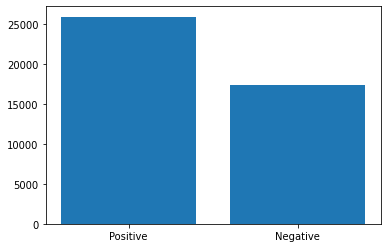

In [ ]:
classes = sorted(df.target.unique())
counts = []
for i in classes: 
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['Positive', 'Negative'], counts)
plt.show()

In [ ]:
df.loc[df.target==0].shape[0], df.loc[df.target==1].shape[0]

(25964, 17401)

In [ ]:
trainX = df.drop('target', axis=1).to_numpy()
trainY = df['target'].to_numpy()
trainX.shape, trainY.shape

((43365, 1), (43365,))

In [ ]:
type(trainX), type(trainY) 

(numpy.ndarray, numpy.ndarray)

### DATA CLEANING

In [ ]:
## Data Cleaning 
import re
trainX = [re.sub("[a-zA-z0-9,১২৩৪৫৬৭৮৯০,@,;.ঃ\_\`\~।\|?:\"$%&#''\-\!\^*(){}\[\]<>—’“”√।\-=+/]+","", str(x)).strip() for x in trainX] 
emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

trainX = [re.sub(emoji,'',x).strip() for x in trainX]

In [ ]:
import re 

def data_cleaning(text): 
  text = [re.sub("[a-zA-z0-9,১২৩৪৫৬৭৮৯০,@,;.ঃ\_\`\~।\|?:\"$%&#''\-\!\^*(){}\[\]<>—’“”√।\-=+/]+","", str(x)).strip() for x in text] 
  emoji = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                        "]+", re.UNICODE)

  text = [re.sub(emoji,'',x).strip() for x in text]
  return text

In [ ]:
trainX[:2]

['খুবেই সুন্দৱ ছবি', 'মাগি মনে হয়ে']

In [ ]:
def stemmer2(word_list): 
    stemmed_word=[]
    end_char = ['ই', 'ও', 'তো', 'কে', 'তে', 'রা','চ্ছি','চ্ছিল','চ্ছে','চ্ছিস','চ্ছিলেন','চ্ছ','য়েছে','েছ','েছে','েছেন']
    
    for word in word_list:
        br=0 
        for stem in end_char: 
            ch = word.split(stem)
            if len(ch)==2:
                if len(ch[1])==0: 
                    stemmed_word.append(ch[0])
                    br=1
                    break               
        if br==0:
            stemmed_word.append(word)
            
    return ' '.join(stemmed_word) 

In [ ]:
def stemmer(word_list): 
    stemmed_word=[]
    end_char = ['ই', 'ও', 'তো', 'কে', 'তে', 'রা','চ্ছি','চ্ছিল','চ্ছে','চ্ছিস',
                'চ্ছিলেন','চ্ছ','য়েছে','েছ', 'েছে','েছেন','ওয়া','েছিলেন',
                'লেন','েন', 'বেন','িস', 'ছিস', 'ছিলি', 'ছি', 'ছে', 
                'লি', 'বি', 'ে', 'টি', 'টির', 'েরটা',
                'েরটার', 'টা', 'টার', 'েরগুলো', 'েরগুলোর', 'গুলো', 
                'গুলোর','দের','ের','ার',] 
    end_char_replace = {
        'রছ':'র',
        'রব' :'র', 
        'েয়ে' : ' া',
        ' েয়েছিল' : ' া',
        ' েয়েছিলেন':' া',
        'ে.েছিলেন' : 'া.',
        ' ে.ে' :' া.'
    }
    for word in word_list:
        word = word.strip()
        br=0 
        for stem in end_char: 
            ch = word.split(stem.strip())
            if len(ch)==2:
                if len(ch[1])==0: 
                    stemmed_word.append(ch[0].strip())
                    br=1
                    break 
                 
        if br==0: 
          for item in end_char_replace: 
            ch = word.split(item.strip())
            if len(ch)==2: 
              if len(ch[1])==0: 
                word = word.strip()
                word = word.replace(item.strip(), end_char_replace[item].strip())
                stemmed_word.append(word.strip())
                br=1
                break            
        if br==0:
            stemmed_word.append(word.strip())

    # word_list = []
    # for word in stemmed_word:
    #     word = word.strip()
    #     br=0 
    #     for stem in end_char: 
    #         ch = word.split(stem.strip())
    #         if len(ch)==2:
    #             if len(ch[1])==0: 
    #                 word_list.append(ch[0].strip())
    #                 br=1
    #                 break 
                 
    #     if br==0: 
    #       for item in end_char_replace: 
    #         ch = word.split(item.strip())
    #         if len(ch)==2: 
    #           if len(ch[1])==0: 
    #             word = word.strip()
    #             word = word.replace(item.strip(), end_char_replace[item].strip())
    #             word_list.append(word.strip())
    #             br=1
    #             break            
    #     if br==0:
    #         word_list.append(word.strip())
    
    return ' '.join(stemmed_word).replace('  ', ' ')

In [ ]:
def remove_stopword2(text):  
    stopwords = pd.read_csv("/content/drive/My Drive/IDP/Dataset/bangla_stopwords.csv")
    stopwords = stopwords.to_numpy()
    stopwords = [s for stop in stopwords for s in stop]
    text = np.char.split(text, sep= ' ')
    text = text.reshape(-1)
    index = []
    for t in text: 
        for i in range(len(t)): 
            if t[i]=='': 
                index.append(i)
    for t in text: 
        t = np.delete(t, index)
        text = t
    
    for t in text: 
        for stop in stopwords: 
            if t == stop and len(t)== len(stop): 
                text = np.char.replace(text, stop, '')
    index = []
    for i in range(len(text)): 
        if text[i]=='':
            index.append(i)
    
    text = np.delete(text, index)
        
    return text

In [ ]:
def remove_stopword(text):
  stopwords = pd.read_csv("bangla_stopwords.csv")
  stopwords = stopwords['text'].to_numpy()
  text = text.split(' ')
  new_text = []
  for  i in range(len(text)):
    if text[i] not in stopwords: 
      new_text.append(text[i])
      
  return new_text

In [ ]:
def remove_punctuation(text): 
    punctuation = [",", ";", "।", "?", "!", ":", "—", "-", "’", "'", "'","“", "”", "(", ")","{", "}","[", "]", "√", "<", ">", "=", ".", "/"]
    for p in punctuation: 
        text = text.translate({ord(p):None})
    return text

### Data preprocessing

In [ ]:
corpus = list()  
for t in trainX:     
    processed_text = remove_stopword(t)
    processed_text = stemmer(processed_text)    
    corpus.append(processed_text) 

In [ ]:
corpus = np.array(corpus)
all_words = [d.split() for d in corpus.tolist()]
all_words[2]

['ভাল', 'লাগলো']

In [ ]:
cc = pd.DataFrame(corpus, columns=['clean_data'])
cc.to_csv('clean_data.csv', index=False)

In [ ]:
all_words[10], trainY[10]

In [ ]:
## Filter one letter word sentences 
index = []
for i in range(len(all_words)):
  if len(all_words[i])==1 and len(all_words[i][0])==1: 
    index.append(i)

all_words = np.delete(np.array(all_words), index).tolist()
trainY= np.delete(trainY, index)
len(all_words), trainY.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


(43342, (43342,))

In [ ]:
updated_words = [[] for x in all_words]
index = []
for i in range(len(all_words)): 
   for j in range(len(all_words[i])): 
      if len(all_words[i][j])>1: 
        updated_words[i].append(all_words[i][j])
len(updated_words)

43342

In [ ]:
all_words = updated_words

In [ ]:
(np.array(all_words).shape), len(trainY)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


((43342,), 43342)

In [ ]:
DIM = 100 
w2v_model = gensim.models.Word2Vec(sentences= all_words,vector_size = DIM, window=10, min_count=1)

In [ ]:
w2v_model.wv.most_similar('আমার')

[('বড়ো', 0.9975153207778931),
 ('দিছ', 0.9972477555274963),
 ('স্টাইল', 0.9972465634346008),
 ('সেলিব্রি', 0.9966008067131042),
 ('নাচ', 0.9965663552284241),
 ('টাইম', 0.9964630603790283),
 ('আপ', 0.9963855147361755),
 ('কাল', 0.9963609576225281),
 ('আন', 0.995980978012085),
 ('বলো', 0.9959729909896851)]

In [ ]:
most_used_words = w2v_model.wv.index_to_key[:100]
least_used_words = w2v_model.wv.index_to_key[::-1]
least_used_words = least_used_words[:100]
least_used_words[:5]

['খুবে', 'মাইয়াদের', 'হেডাখোদায়', 'ন্যয', 'গেযানী']

In [ ]:
updated_words = [[] for x in all_words for t in x]
for i in range(len(all_words)): 
  for j in range(len(all_words[i])): 
    if all_words[i][j] not in most_used_words and all_words[i][j] not in least_used_words:
      updated_words[i].append(all_words[i][j])   

updated_words = [ele for ele in updated_words if ele != []]
len(updated_words)

42462

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_words)
all_words_seq = tokenizer.texts_to_sequences(all_words)
all_words_seq[:5]

[[19812, 10391],
 [23, 13],
 [49, 326],
 [28, 63, 3115, 6, 545, 132, 7524, 10392],
 [34, 5945]]

In [ ]:
vocab_size = len(tokenizer.word_index) + 1 
vocab_size

51680

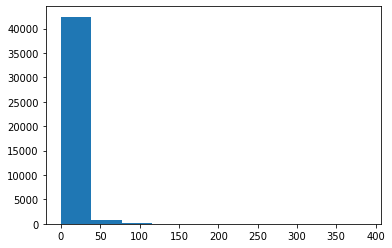

In [ ]:
plt.hist([len(x) for x in all_words_seq])
plt.show()

In [ ]:
nos = np.array([len(x) for x in all_words])
len(nos[nos>80])

197

In [ ]:
sentence_length = 100 
embedded_docs = pad_sequences(all_words_seq, maxlen=sentence_length)
embedded_docs

array([[    0,     0,     0, ...,     0, 19812, 10391],
       [    0,     0,     0, ...,     0,    23,    13],
       [    0,     0,     0, ...,     0,    49,   326],
       ...,
       [    0,     0,     0, ...,     0,     0,  7436],
       [    0,     0,     0, ..., 51675,   990,  2675],
       [    0,     0,     0, ...,  7691,   260,   614]], dtype=int32)

In [ ]:
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model): 
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items(): 
        try:
            weight_matrix[i] = model.wv[word]
        except: 
            print('word: {}'.format(word))
    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape

word: äâ
word: ṝῡ
word: এঁঈҕῷῷ
word: ôïø
word: গোñমাংস


(51680, 100)

In [ ]:
X_final = np.array(embedded_docs)
y_final = np.array(trainY)

### Creating `LSTM` Model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim= DIM, weights=[embedding_vectors], input_length= sentence_length))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(512, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 100)          5168000   
                                                                 
 batch_normalization_13 (Bat  (None, 100, 100)         400       
 chNormalization)                                                
                                                                 
 lstm_42 (LSTM)              (None, 100, 64)           42240     
                                                                 
 dropout_16 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_43 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                     

In [ ]:
history1 = model.fit(X_final, y_final, validation_split=0.2, epochs=3, batch_size=64)

Epoch 1/3
542/542 [==============================] - 161s 298ms/step - loss: 0.0910 - accuracy: 0.9674 - val_loss: 0.6740 - val_accuracy: 0.8537
Epoch 2/3
 11/542 [..............................] - ETA: 2:30 - loss: 0.0475 - accuracy: 0.9844

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim= DIM, weights=[embedding_vectors], input_length= sentence_length, trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5929300   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 64)           42240     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [ ]:
X_final = np.array(embedded_docs)
y_final = np.array(trainY)

In [ ]:
def plot_acc(acc, val_acc):
  fig, ax = plt.subplots() 
  ax.plot(val_acc, '-ro', label='Val_Acc')
  ax.plot(acc, '-bo', label='Acc')
  ax.legend()
  ax.set_title('ACC vs Val_ACC')
  plt.show()

def plot_loss(loss, val_loss): 
  fig, ax = plt.subplots() 
  ax.plot(val_loss, '-ro', label='Val_Loss')
  ax.plot(loss, '-bo', label='Loss')
  ax.legend()
  ax.set_title('LOSS vs Val_LOSS')
  plt.show()

In [ ]:
history1 = model.fit(X_final, y_final, validation_split=0.3, epochs=10, batch_size=128)
history1

Epoch 1/10
238/238 [==============================] - 136s 554ms/step - loss: 0.4730 - accuracy: 0.7882 - val_loss: 0.4311 - val_accuracy: 0.8061
Epoch 2/10
238/238 [==============================] - 130s 546ms/step - loss: 0.4293 - accuracy: 0.8103 - val_loss: 0.4131 - val_accuracy: 0.8179
Epoch 3/10
238/238 [==============================] - 130s 548ms/step - loss: 0.4140 - accuracy: 0.8175 - val_loss: 0.4223 - val_accuracy: 0.8112
Epoch 4/10
238/238 [==============================] - 130s 547ms/step - loss: 0.4103 - accuracy: 0.8182 - val_loss: 0.4046 - val_accuracy: 0.8231
Epoch 5/10
238/238 [==============================] - 130s 545ms/step - loss: 0.4048 - accuracy: 0.8223 - val_loss: 0.4003 - val_accuracy: 0.8252
Epoch 6/10
238/238 [==============================] - 130s 548ms/step - loss: 0.4020 - accuracy: 0.8231 - val_loss: 0.3944 - val_accuracy: 0.8263
Epoch 7/10
238/238 [==============================] - 130s 546ms/step - loss: 0.3994 - accuracy: 0.8229 - val_loss: 0.3853 -

In [ ]:
history1_model1 = model.fit(X_final, y_final, validation_split=0.3, epochs=15, batch_size=128)

Epoch 1/15
238/238 [==============================] - 154s 646ms/step - loss: 0.3912 - accuracy: 0.8259 - val_loss: 0.3858 - val_accuracy: 0.8261
Epoch 2/15
238/238 [==============================] - 155s 650ms/step - loss: 0.3899 - accuracy: 0.8258 - val_loss: 0.3837 - val_accuracy: 0.8290
Epoch 3/15
238/238 [==============================] - 153s 642ms/step - loss: 0.3876 - accuracy: 0.8259 - val_loss: 0.3836 - val_accuracy: 0.8304
Epoch 4/15
238/238 [==============================] - 164s 690ms/step - loss: 0.3862 - accuracy: 0.8287 - val_loss: 0.3855 - val_accuracy: 0.8273
Epoch 5/15
238/238 [==============================] - 160s 670ms/step - loss: 0.3849 - accuracy: 0.8282 - val_loss: 0.3794 - val_accuracy: 0.8288
Epoch 6/15
238/238 [==============================] - 153s 644ms/step - loss: 0.3815 - accuracy: 0.8301 - val_loss: 0.3849 - val_accuracy: 0.8293
Epoch 7/15
238/238 [==============================] - 151s 634ms/step - loss: 0.3834 - accuracy: 0.8290 - val_loss: 0.3829 -

In [ ]:
result1_val_acc = history1.history['val_accuracy'] + history1_model1.history['val_accuracy'] 
result1_acc = history1.history['accuracy'] + history1_model1.history['accuracy']
result1_loss =history1.history['loss'] + history1_model1.history['loss'] 
result1_val_loss = history1.history['val_loss'] + history1_model1.history['val_loss'] 


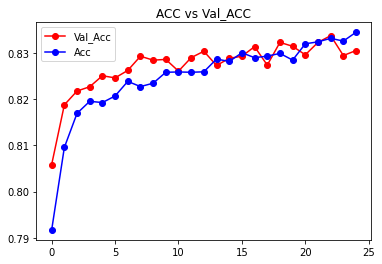

In [ ]:
plot_acc(result1_acc, result1_val_acc)

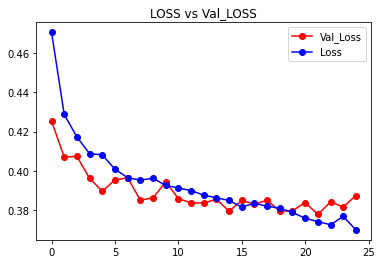

In [ ]:
plot_loss(result1_loss, result1_val_loss)

#### **Saving a model**

In [ ]:
ls checkpoints

checkpoint                         my_checkpoint.h5
my_checkpoint.data-00000-of-00001  my_checkpoint.index


In [ ]:
model.save_weights('./checkpoints/my_checkpoint.h5')

In [ ]:
model.save('model.h5')

### Creating `Bidirectional LSTM` Model

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, output_dim= DIM, weights=[embedding_vectors], input_length= sentence_length, trainable=False))
model1.add(Dropout(0.1))
model1.add(Bidirectional(LSTM(64, return_sequences = True)))
model1.add(Bidirectional(LSTM(128)))
model1.add(Dropout(0.1))
model1.add(Dense(512))
model1.add(Dense(128))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()


In [ ]:
history2= model1.fit(X_final, y_final, validation_split=0.3, epochs=30, batch_size=128)
history2

Epoch 1/30
238/238 [==============================] - 46s 149ms/step - loss: 0.4580 - accuracy: 0.7967 - val_loss: 0.4207 - val_accuracy: 0.8152
Epoch 2/30
238/238 [==============================] - 34s 141ms/step - loss: 0.4223 - accuracy: 0.8156 - val_loss: 0.4207 - val_accuracy: 0.8169
Epoch 3/30
238/238 [==============================] - 34s 141ms/step - loss: 0.4072 - accuracy: 0.8204 - val_loss: 0.3956 - val_accuracy: 0.8236
Epoch 4/30
238/238 [==============================] - 34s 142ms/step - loss: 0.4045 - accuracy: 0.8236 - val_loss: 0.3918 - val_accuracy: 0.8271
Epoch 5/30
238/238 [==============================] - 33s 141ms/step - loss: 0.3979 - accuracy: 0.8247 - val_loss: 0.3887 - val_accuracy: 0.8298
Epoch 6/30
238/238 [==============================] - 34s 141ms/step - loss: 0.3931 - accuracy: 0.8266 - val_loss: 0.3931 - val_accuracy: 0.8228
Epoch 7/30
238/238 [==============================] - 34s 142ms/step - loss: 0.3937 - accuracy: 0.8258 - val_loss: 0.3862 - val_ac

In [ ]:
model1.save('model1.h5')

In [ ]:
history2_model2 = model1.fit(X_final, y_final, validation_split=0.3, epochs=20, batch_size=64)

Epoch 1/20
363/363 [==============================] - 10s 26ms/step - loss: 0.4531 - accuracy: 0.7908 - val_loss: 0.4565 - val_accuracy: 0.7863
Epoch 2/20
363/363 [==============================] - 8s 23ms/step - loss: 0.4443 - accuracy: 0.7933 - val_loss: 0.4341 - val_accuracy: 0.7981
Epoch 3/20
363/363 [==============================] - 8s 23ms/step - loss: 0.4397 - accuracy: 0.7948 - val_loss: 0.4379 - val_accuracy: 0.7980
Epoch 4/20
363/363 [==============================] - 8s 23ms/step - loss: 0.4353 - accuracy: 0.7983 - val_loss: 0.4274 - val_accuracy: 0.8014
Epoch 5/20
363/363 [==============================] - 8s 22ms/step - loss: 0.4301 - accuracy: 0.7995 - val_loss: 0.4305 - val_accuracy: 0.7993
Epoch 6/20
363/363 [==============================] - 8s 22ms/step - loss: 0.4270 - accuracy: 0.8000 - val_loss: 0.4229 - val_accuracy: 0.8027
Epoch 7/20
363/363 [==============================] - 8s 23ms/step - loss: 0.4252 - accuracy: 0.8010 - val_loss: 0.4243 - val_accuracy: 0.801

In [ ]:
from google.colab import files
files.download('model4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model4.evaluate(X_test, y_test)

271/271 [==============================] - 11s 39ms/step - loss: 0.3498 - accuracy: 0.8452


[0.3497617840766907, 0.8452312350273132]

In [ ]:
model4.weights[0]

<tf.Variable 'embedding_3/embeddings:0' shape=(59293, 100) dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-9.8586702e-01,  1.4085649e+00,  7.0996180e-02, ...,
        -1.6380746e+00,  6.5753096e-01,  5.7048678e-01],
       [-1.0634031e+00,  1.6918726e+00,  4.8643455e-01, ...,
        -1.8453096e+00,  6.5694803e-01,  9.8806095e-01],
       ...,
       [-6.2414067e-04,  1.6955761e-02, -4.5120143e-03, ...,
        -5.0818636e-03,  1.2397649e-02, -6.3497499e-03],
       [-9.4274124e-03,  1.6535176e-02,  4.6778340e-03, ...,
        -1.0450720e-03,  2.9619767e-03, -5.9068864e-03],
       [-1.4193320e-02,  1.2483997e-02,  1.4082339e-04, ...,
         2.9466895e-03,  9.0594627e-03,  5.5697495e-03]], dtype=float32)>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Saving model1 
model1.save('model2.h5')
model1.save_weights('./checkpoints/model2.h5')

In [ ]:
result2_val_acc = history2.history['val_accuracy'] + history2_model2.history['val_accuracy'] +history2_model2_1.history['val_accuracy']  
result2_acc = history2.history['accuracy'] + history2_model2.history['accuracy'] + history2_model2_1.history['accuracy']  
result2_loss =history2.history['loss'] + history2_model2.history['loss'] + history2_model2_1.history['loss']  
result2_val_loss = history2.history['val_loss'] + history2_model2.history['val_loss'] + history2_model2_1.history['val_loss']  

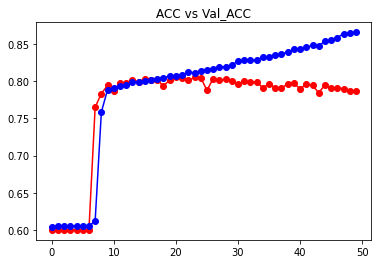

In [ ]:
plot_acc(result2_acc, result2_val_acc)

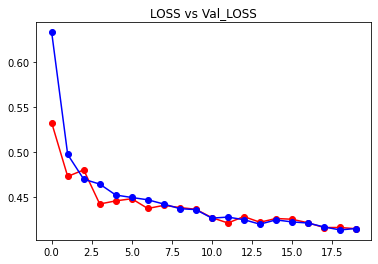

In [ ]:
plot_loss(result2_loss, result2_val_loss)

### Creating `GRU` Model

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size, output_dim= DIM, weights=[embedding_vectors], input_length= sentence_length, trainable=False))
model3.add(Dropout(0.1))
model3.add(layers.GRU(64, return_sequences=True))
model3.add(layers.GRU(128))
model3.add(Dropout(0.1))
model3.add(Dense(512))
model3.add(Dense(256))
model3.add(Dense(128))
model3.add(Dense(64))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5174200   
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 gru_2 (GRU)                 (None, 100, 64)           31872     
                                                                 
 gru_3 (GRU)                 (None, 128)               74496     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               66048     
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
history3 = model3.fit(X_final, y_final, validation_split=0.2, epochs=15, batch_size=128)
history3

Epoch 1/15
271/271 [==============================] - 16s 18ms/step - loss: 0.4566 - accuracy: 0.7968 - val_loss: 0.4318 - val_accuracy: 0.8179
Epoch 2/15
271/271 [==============================] - 4s 15ms/step - loss: 0.4096 - accuracy: 0.8186 - val_loss: 0.3930 - val_accuracy: 0.8239
Epoch 3/15
271/271 [==============================] - 4s 15ms/step - loss: 0.3999 - accuracy: 0.8251 - val_loss: 0.3887 - val_accuracy: 0.8301
Epoch 4/15
271/271 [==============================] - 4s 15ms/step - loss: 0.3936 - accuracy: 0.8262 - val_loss: 0.3828 - val_accuracy: 0.8325
Epoch 5/15
271/271 [==============================] - 4s 15ms/step - loss: 0.3848 - accuracy: 0.8309 - val_loss: 0.3864 - val_accuracy: 0.8338
Epoch 6/15
271/271 [==============================] - 4s 15ms/step - loss: 0.3837 - accuracy: 0.8326 - val_loss: 0.3855 - val_accuracy: 0.8308
Epoch 7/15
271/271 [==============================] - 4s 15ms/step - loss: 0.3798 - accuracy: 0.8334 - val_loss: 0.3773 - val_accuracy: 0.836

In [ ]:
model3.save('./Model3_tf',save_format='tf')

INFO:tensorflow:Assets written to: ./Model3_tf/assets


INFO:tensorflow:Assets written to: ./Model3_tf/assets


In [ ]:
model3.evaluate(X_final, y_final, verbose=0)

[0.3459795415401459, 0.8495454788208008]

In [ ]:
another_model = tf.keras.models.load_model('/content/drive/My Drive/IDP/model3.h5')
another_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5174200   
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 gru_2 (GRU)                 (None, 100, 64)           31872     
                                                                 
 gru_3 (GRU)                 (None, 128)               74496     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               66048     
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
another_model.evaluate(X_final, y_final, verbose=0)

[0.3459795415401459, 0.8495454788208008]

In [ ]:
model3.save('model3.h5')

In [ ]:
history3_model3 = model3.fit(X_final, y_final, validation_split=0.2, epochs=20, batch_size=128)


Epoch 1/20
271/271 [==============================] - 17s 62ms/step - loss: 0.3341 - accuracy: 0.8532 - val_loss: 0.3865 - val_accuracy: 0.8342
Epoch 2/20
271/271 [==============================] - 17s 61ms/step - loss: 0.3289 - accuracy: 0.8560 - val_loss: 0.3919 - val_accuracy: 0.8307
Epoch 3/20
271/271 [==============================] - 17s 61ms/step - loss: 0.3251 - accuracy: 0.8582 - val_loss: 0.3854 - val_accuracy: 0.8316
Epoch 4/20
271/271 [==============================] - 17s 61ms/step - loss: 0.3198 - accuracy: 0.8619 - val_loss: 0.3973 - val_accuracy: 0.8342
Epoch 5/20
271/271 [==============================] - 17s 62ms/step - loss: 0.3160 - accuracy: 0.8623 - val_loss: 0.3927 - val_accuracy: 0.8365
Epoch 6/20
271/271 [==============================] - 17s 61ms/step - loss: 0.3110 - accuracy: 0.8657 - val_loss: 0.3966 - val_accuracy: 0.8313
Epoch 7/20
271/271 [==============================] - 17s 61ms/step - loss: 0.3039 - accuracy: 0.8680 - val_loss: 0.3992 - val_accuracy:

### Creating `Bidirectional GRU` Model

In [ ]:
model4 = Sequential()
model4.add(Embedding(vocab_size, output_dim= DIM, weights=[embedding_vectors], input_length= sentence_length, trainable=False))
model4.add(Dropout(0.1))
model4.add(Bidirectional(layers.GRU(64, return_sequences=True)))
model4.add(Bidirectional(layers.GRU(128)))
model4.add(Dropout(0.1))
model4.add(Dense(512))
model4.add(Dense(256))
model4.add(Dense(128))
model4.add(Dense(64))
model4.add(Dense(1,activation='sigmoid'))
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

In [ ]:
history4 = model4.fit(X_final, y_final, validation_split=0.2, epochs=30, batch_size=64)

Epoch 1/30
542/542 [==============================] - 78s 116ms/step - loss: 0.4506 - accuracy: 0.7998 - val_loss: 0.4124 - val_accuracy: 0.8221
Epoch 2/30
542/542 [==============================] - 61s 113ms/step - loss: 0.4137 - accuracy: 0.8173 - val_loss: 0.3881 - val_accuracy: 0.8267
Epoch 3/30
542/542 [==============================] - 61s 113ms/step - loss: 0.4029 - accuracy: 0.8221 - val_loss: 0.3831 - val_accuracy: 0.8284
Epoch 4/30
542/542 [==============================] - 61s 113ms/step - loss: 0.3984 - accuracy: 0.8252 - val_loss: 0.3831 - val_accuracy: 0.8295
Epoch 5/30
542/542 [==============================] - 61s 113ms/step - loss: 0.3954 - accuracy: 0.8266 - val_loss: 0.3864 - val_accuracy: 0.8264
Epoch 6/30
542/542 [==============================] - 61s 113ms/step - loss: 0.3904 - accuracy: 0.8276 - val_loss: 0.3778 - val_accuracy: 0.8332
Epoch 7/30
542/542 [==============================] - 61s 113ms/step - loss: 0.3879 - accuracy: 0.8298 - val_loss: 0.3821 - val_ac

In [ ]:
model4.save('model4.h5')

In [ ]:
model4.weights[0]

<tf.Variable 'embedding_3/embeddings:0' shape=(59293, 100) dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-9.8586702e-01,  1.4085649e+00,  7.0996180e-02, ...,
        -1.6380746e+00,  6.5753096e-01,  5.7048678e-01],
       [-1.0634031e+00,  1.6918726e+00,  4.8643455e-01, ...,
        -1.8453096e+00,  6.5694803e-01,  9.8806095e-01],
       ...,
       [-6.2414067e-04,  1.6955761e-02, -4.5120143e-03, ...,
        -5.0818636e-03,  1.2397649e-02, -6.3497499e-03],
       [-9.4274124e-03,  1.6535176e-02,  4.6778340e-03, ...,
        -1.0450720e-03,  2.9619767e-03, -5.9068864e-03],
       [-1.4193320e-02,  1.2483997e-02,  1.4082339e-04, ...,
         2.9466895e-03,  9.0594627e-03,  5.5697495e-03]], dtype=float32)>

In [ ]:
history3_model3_1 = model3.fit(X_final, y_final, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
415/415 [==============================] - 23s 56ms/step - loss: 0.3581 - accuracy: 0.8367 - val_loss: 0.4153 - val_accuracy: 0.8136
Epoch 2/10
415/415 [==============================] - 26s 62ms/step - loss: 0.3552 - accuracy: 0.8355 - val_loss: 0.4174 - val_accuracy: 0.8069
Epoch 3/10
415/415 [==============================] - 23s 56ms/step - loss: 0.3476 - accuracy: 0.8396 - val_loss: 0.4248 - val_accuracy: 0.8054
Epoch 4/10
415/415 [==============================] - 23s 56ms/step - loss: 0.3371 - accuracy: 0.8462 - val_loss: 0.4220 - val_accuracy: 0.8003
Epoch 5/10
415/415 [==============================] - 23s 55ms/step - loss: 0.3269 - accuracy: 0.8498 - val_loss: 0.4507 - val_accuracy: 0.8027
Epoch 6/10
415/415 [==============================] - 23s 55ms/step - loss: 0.3191 - accuracy: 0.8558 - val_loss: 0.4711 - val_accuracy: 0.7985
Epoch 7/10
415/415 [==============================] - 23s 55ms/step - loss: 0.3022 - accuracy: 0.8645 - val_loss: 0.4549 - val_accuracy:

In [ ]:
result3_val_acc = history3.history['val_accuracy'] + history3_model3.history['val_accuracy'] 
result3_acc = history3.history['accuracy'] + history3_model3.history['accuracy']
result3_loss =history3.history['loss'] + history3_model3.history['loss'] 
result3_val_loss = history3.history['val_loss'] + history3_model3.history['val_loss'] 

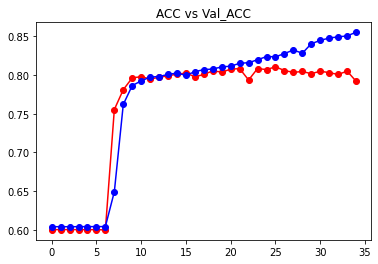

In [ ]:
plot_acc(result3_acc, result3_val_acc)

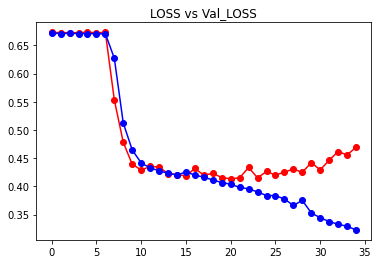

In [ ]:
plot_loss(result3_loss, result3_val_loss)

In [ ]:
from sklearn import svm 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=8)


In [ ]:
clf = svm.SVC()
clf.fit(X_train_vect, train_df['target'].values)

SVC()

In [ ]:
pred_svm = clf.predict(vect.transform(test_df['text'].values))
pred_svm

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
score_svm  = metrics.accuracy_score(test_df['target'].values, pred_log)
print("accuracy {:.6f}".format(score_svm))

accuracy 0.719935


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_vect, train_df.target.values)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
pred_neigh = neigh.predict(vect.transform(test_df.text.values))

In [ ]:
score_neigh  = metrics.accuracy_score(test_df['target'].values, pred_neigh)
print("accuracy {:.6f}".format(score_neigh))

accuracy 0.648565


In [ ]:
y_train.shape, X_train.shape

((23202,), (23202, 100))

In [ ]:
!pip install keras-tuner

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
def build_model(hp):
    model4 = Sequential()
    model4.add(Embedding(vocab_size, output_dim= DIM, weights=[embedding_vectors], input_length= sentence_length, trainable=False))
    model4.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 3)):
        model4.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model4.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model4.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model4.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model4.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model4

In [ ]:
tuner= RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=3
        )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}


In [ ]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test))

Trial 5 Complete [00h 06m 31s]
val_accuracy: 0.605390191078186

Best val_accuracy So Far: 0.6291901270548502
Total elapsed time: 00h 33m 23s
INFO:tensorflow:Oracle triggered exit


### Creating a function whether it is abusive or not

In [ ]:
def get_prediction(text): 
  text = re.sub("[a-zA-z0-9,১২৩৪৫৬৭৮৯০,@,;.ঃ\_\`\’‘~।\|?:\"$%&#''\-\!\^*(){}\[\]<>—’“”√।\-=+/]+","", text).strip() 
  emoji = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002500-\U00002BEF"  # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                        "]+", re.UNICODE)

  text = re.sub(emoji,'',text).strip() 

  text = remove_stopword(text)
  text = stemmer(text)
  text = [text]
  tokenizer = Tokenizer()
  text = tokenizer.texts_to_sequences(text)
  text = pad_sequences(text, maxlen=sentence_length)
  model = tf.keras.models.load_models('transformer-higher-acc-model')
  prediction = 'Abusive' if (model4.predict(text)>0.6).astype(int)[0][0] else 'Not abusive'
  how_much_abusive = model4.predict(text)[0][0] 
  return prediction

### Bert Model Testing

In [ ]:
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')


In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')


In [ ]:
def get_sentence_embedding(sentences): 
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
get_sentence_embedding(['আমার সোনার বাংলা',
                        'বিভ বনানীতে মজায় মগ্ন। জিবনে কম মজা পায় নাই এই ছেলে।'
                        ])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8569263 , -0.17284942, -0.43768346, ..., -0.46544355,
        -0.5820018 ,  0.8221333 ],
       [-0.524208  ,  0.20055073,  0.32789513, ..., -0.07186333,
        -0.08007434,  0.3925424 ]], dtype=float32)>

In [ ]:
e = get_sentence_embedding(['কলা', 'আপেল', 'বিভ', 'তরমুজ','বাংলা','ভাষা'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity  

cosine_similarity([e[1]],[e[2]])

array([[0.913604]], dtype=float32)

In [ ]:
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessed_text = bert_preprocess(text_input)
outputs = bert_layer(preprocessed_text)

l = tf.keras.layers.Dropout(0.3, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

model = keras.Model(inputs=[text_input], outputs=[l])

model.compile(optimizer='adam', 
              loss= 'binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
model.fit(X_final, y_final, epochs=5)

In [ ]:
xb_train = np.array(xb_train)
yb_train = np.array(yb_train)

In [ ]:
type(yb_train), type(xb_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
xb_train = tf.convert_to_tensor(xb_train)
xb_train

In [ ]:
X_train.shape

(34680, 100)

### BERT Model Using `ktrain` 

In [ ]:
!pip install ktrain

In [ ]:
import ktrain
from ktrain import text

In [ ]:
df['text'] = data_cleaning(df['text'])
corpus = list()  
for t in df['text']:     
    processed_text = remove_stopword(t)
    processed_text = stemmer(processed_text)    
    corpus.append(processed_text) 

In [ ]:
type(corpus)

list

In [ ]:
df['text'] = corpus
df['target']= [int(i) for i in df.target.values]

In [ ]:
df.isna().sum()

text      0
target    0
dtype: int64

In [ ]:
split = int(df.shape[0]*.8)
train_df = df[:split]
test_df = df[split:]
train_df.shape[0] + test_df.shape[0], df.shape[0]

(43365, 43365)

In [ ]:
(xb_train, yb_train), (xb_test, yb_test), preprocess = text.texts_from_df(train_df=df, 
                   text_column = 'text', 
                   label_columns = 'target', 
                   val_df = test_df, 
                   maxlen = 100, 
                   preprocess_mode = 'bert')

['not_target', 'target']
       not_target  target
13146         1.0     0.0
9430          0.0     1.0
20629         1.0     0.0
1786          0.0     1.0
1373          0.0     1.0
['not_target', 'target']
       not_target  target
23164         1.0     0.0
20546         1.0     0.0
11611         1.0     0.0
7803          1.0     0.0
28561         1.0     0.0
preprocessing train...
language: bn


Is Multi-Label? False
preprocessing test...
language: bn


In [ ]:
xb_train[0].shape

(43365, 100)

In [ ]:
Bert_model = text.text_classifier(name='bert', 
                                  train_data = (xb_train, yb_train), 
                                  preproc = preprocess
                                  ) 

Is Multi-Label? False
maxlen is 100
done.


In [ ]:
## Get learning rate 
learner = ktrain.get_learner(model= Bert_model, 
                             train_data=(xb_train, yb_train), 
                             val_data =(xb_test, yb_test), 
                             batch_size = 16)

> This might take days to run 
```
`learner.lr_find()`
`learner.lr_plot()`
```


> Optimal learning rate for this model is `2e-5`  

##### Training BERT Model

In [ ]:
bert_history = learner.fit_onecycle(lr=2e-5 , epochs=2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2711/2711 [==============================] - 1156s 414ms/step - loss: 0.4011 - accuracy: 0.8244 - val_loss: 0.3149 - val_accuracy: 0.8722
Epoch 2/2
2711/2711 [==============================] - 1119s 413ms/step - loss: 0.3014 - accuracy: 0.8780 - val_loss: 0.2334 - val_accuracy: 0.9056


In [ ]:
bert_history1 = learner.fit_onecycle(lr=2e-5 , epochs=1)



begin training using onecycle policy with max lr of 2e-05...
2711/2711 [==============================] - 1125s 415ms/step - loss: 0.2100 - accuracy: 0.9160 - val_loss: 0.1423 - val_accuracy: 0.9453


In [ ]:
bert_history2 = learner.fit_onecycle(lr=2e-5 , epochs=1)



begin training using onecycle policy with max lr of 2e-05...
2711/2711 [==============================] - 1123s 414ms/step - loss: 0.1864 - accuracy: 0.9260 - val_loss: 0.1164 - val_accuracy: 0.9607


In [ ]:
bert_history3 = learner.fit_onecycle(lr=2e-5 , epochs=2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2711/2711 [==============================] - 1121s 414ms/step - loss: 0.1546 - accuracy: 0.9393 - val_loss: 0.1136 - val_accuracy: 0.9560
Epoch 2/2
2711/2711 [==============================] - 1124s 414ms/step - loss: 0.1389 - accuracy: 0.9469 - val_loss: 0.0530 - val_accuracy: 0.9832


In [ ]:
bert_history4 = learner.fit_onecycle(lr=2e-5 , epochs=2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2711/2711 [==============================] - 1124s 414ms/step - loss: 0.1033 - accuracy: 0.9612 - val_loss: 0.0732 - val_accuracy: 0.9739
Epoch 2/2
2711/2711 [==============================] - 1122s 414ms/step - loss: 0.1031 - accuracy: 0.9617 - val_loss: 0.0303 - val_accuracy: 0.9919


In [ ]:
bert_history5 = learner.fit_onecycle(lr=2e-5 , epochs=2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2711/2711 [==============================] - 1121s 414ms/step - loss: 0.0723 - accuracy: 0.9744 - val_loss: 0.0516 - val_accuracy: 0.9833
Epoch 2/2
2711/2711 [==============================] - 1121s 413ms/step - loss: 0.0772 - accuracy: 0.9711 - val_loss: 0.0188 - val_accuracy: 0.9939


In [ ]:
bert_history6 = learner.fit_onecycle(lr=2e-5 , epochs=2)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2711/2711 [==============================] - 1122s 414ms/step - loss: 0.0559 - accuracy: 0.9800 - val_loss: 0.0344 - val_accuracy: 0.9890
Epoch 2/2
2711/2711 [==============================] - 1120s 413ms/step - loss: 0.0625 - accuracy: 0.9776 - val_loss: 0.0150 - val_accuracy: 0.9957


In [ ]:
bert_history7 = learner.fit_onecycle(lr=2e-5 , epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
2711/2711 [==============================] - 1122s 414ms/step - loss: 0.0379 - accuracy: 0.9865 - val_loss: 0.0213 - val_accuracy: 0.9934
Epoch 2/3
2711/2711 [==============================] - 1120s 413ms/step - loss: 0.0653 - accuracy: 0.9764 - val_loss: 0.0237 - val_accuracy: 0.9923
Epoch 3/3
2711/2711 [==============================] - 1120s 413ms/step - loss: 0.0345 - accuracy: 0.9877 - val_loss: 0.0096 - val_accuracy: 0.9971


##### Downloading Bert Model

In [ ]:
from google.colab import files
files.download('bert_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
learner.fit_onecycle(lr=2e-5 , epochs=1)



begin training using onecycle policy with max lr of 2e-05...
7228/7228 [==============================] - 2532s 350ms/step - loss: 0.2974 - accuracy: 0.8809 - val_loss: 0.2319 - val_accuracy: 0.9064


In [ ]:
Bert_model.weights[0]

In [ ]:
Bert_model.save('bert_model_epoch2.h5')

#### Bert Prediction

In [ ]:
bert_predictor = ktrain.get_predictor(learner.model, preprocess)

In [ ]:
bert_predictor.save()

In [ ]:
bibh = ['বিভ বনানীতে মজায় মগ্ন। জিবনে কম মজা পায় নাই এই ছেলে।', 'ভাল ছেলে']

bert_predictor.predict(bibh)

['not_target', 'not_target', 'target']

### Tf-idf Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfv = TfidfVectorizer(min_df=3, max_features=None, ngram_range=(1,3))

In [ ]:
vect = tfv.fit(train_df['text'].values)

In [ ]:
len(vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


12131

In [ ]:
X_train_vect = vect.transform(train_df['text'].values)

In [ ]:
X_train_vect[0]

<1x12131 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression 
model_log = LogisticRegression()

model_log.fit(X_train_vect, train_df['target'].values)

LogisticRegression()

In [ ]:
pred_log = model_log.predict(vect.transform(test_df['text'].values))

In [ ]:
# Compute AUC 
from sklearn.metrics import roc_auc_score 
from sklearn import metrics
roc_auc_score(test_df['target'].values, pred_log)

0.680268770084721

In [ ]:
score_log = metrics.accuracy_score(test_df['target'].values, pred_log)
print("accuracy {:.6f}".format(score_log))

accuracy 0.719935


In [ ]:
history_idf = model3.fit(np.array(X_train_vect), df.target.values, validation_split=0.2, epochs=10, batch_size=64)


In [ ]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model_log.coef_[0].argsort()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
